# Optimization project Iver & Alessandro 

In [1]:
import gurobipy as gp
from gurobipy import GRB
from enum import Enum
import numpy as np
from functools import lru_cache
import tkinter as tk

# Taxi game

In [2]:
TAXI_MAP_SIZE = 5

class TaxiTile(Enum):
    EMPTY = 0
    BUILDING = 1
    PICK_UP = 2
    DROP_OFF = 3

    def __eq__(self, other):
        if  other.__class__ is self.__class__:
            return self.value == other.value
        elif self.value == other:
            return True
        else:
            return False


# Remember to index as [y, x]
taxi_mappy = np.array(
[
    [0, 1, 0, 0, 0,],
    [0, 0, 0, 1, 0,],
    [0, 1, 0, 1, 3,],
    [0, 1, 0, 0, 0,],
    [2, 1, 1, 0, 0,]
])

In [3]:
class TaxiAction(Enum):
    MOVE_SOUTH = 0
    MOVE_NORTH = 1
    MOVE_EAST = 2
    MOVE_WEST = 3
    PICK_UP = 4
    DROP_OFF = 5


class FaultyPassengerAction(Exception):
    pass


class FaultyMove(Exception):
    pass


def taxi_do_action(x, y, passenger, action) -> tuple[int, int, bool, Exception | None]:
    if action == TaxiAction.PICK_UP:
        if passenger or taxi_mappy[x, y] != TaxiTile.PICK_UP:
            return x, y, passenger, FaultyPassengerAction
        return x, y, True, None
    elif action == TaxiAction.DROP_OFF:
        if (not passenger) or taxi_mappy[x, y] != TaxiTile.DROP_OFF:
            return x, y, passenger, FaultyPassengerAction
        return x, y, False, None

    nx, ny = x, y
    if action == TaxiAction.MOVE_NORTH:
        nx -= 1
    elif action == TaxiAction.MOVE_SOUTH:
        nx += 1
    elif action == TaxiAction.MOVE_EAST:
        ny += 1
    elif action == TaxiAction.MOVE_WEST:
        ny -= 1

    if nx < 0 or ny < 0 or nx >= TAXI_MAP_SIZE or ny >= TAXI_MAP_SIZE:
        return x, y, passenger, FaultyMove
    elif taxi_mappy[nx, ny] == TaxiTile.BUILDING:
        return x, y, passenger, FaultyMove
    else:
        return nx, ny, passenger, None


def taxi_get_idx(x: int, y: int, passenger: int | bool) -> int:
    return x + y * TAXI_MAP_SIZE + int(passenger) * TAXI_MAP_SIZE * TAXI_MAP_SIZE


def taxi_get_state(idx: int) -> tuple[int, int, bool]:
    passenger = idx // (TAXI_MAP_SIZE * TAXI_MAP_SIZE)
    rest = idx % (TAXI_MAP_SIZE * TAXI_MAP_SIZE)
    y = rest // TAXI_MAP_SIZE
    x = idx % TAXI_MAP_SIZE
    return x, y, bool(passenger)


_tst_state = 2, 3, True
_tst_state_2 = taxi_get_state(taxi_get_idx(_tst_state[0], _tst_state[1], _tst_state[2]))
assert _tst_state_2 == _tst_state


def taxi_iterstates():
    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            if taxi_mappy[x, y] == TaxiTile.BUILDING:
                # Skip all buildings
                continue
            for passenger in [0, 1]:
                yield x, y, passenger

In [4]:
taxi_m = gp.Model("taxi_driver")
# m.params.LogToConsole = 0

# Vs[y, x, passenger] => Value of state
taxi_V = np.empty((TAXI_MAP_SIZE * TAXI_MAP_SIZE * 2), dtype=object)
# choices[y, x, p, ny, nx, np] => probability of transition
taxi_gamma = 0.99

for x, y, passenger in taxi_iterstates():
    # Insert a state
    taxi_V[taxi_get_idx(x, y, passenger)] = taxi_m.addVar()
for x, y, passenger in taxi_iterstates():
    # Create list of all transitions away from this given state
    for action in TaxiAction:
        reward = -1  # For using a timestep

        nx, ny, npass, error = taxi_do_action(x, y, passenger, action)
        if error == FaultyPassengerAction:
            reward -= 10
        elif action == TaxiAction.DROP_OFF:
            # Successfull drop off
            reward += 20
        elif error == FaultyMove:
            continue  # Skip all impossible moves

        taxi_m.addConstr(
            taxi_V[taxi_get_idx(x, y, passenger)]
            >= reward + taxi_gamma * taxi_V[taxi_get_idx(nx, ny, npass)]
        )

taxi_m.setObjective(
    (1 - taxi_gamma) * gp.quicksum(taxi_V[taxi_V != None]),
    sense=GRB.MINIMIZE,
)

taxi_m.optimize()

taxi_Q = np.zeros((TAXI_MAP_SIZE * TAXI_MAP_SIZE * 2, len(TaxiAction)))
for x, y, passenger in taxi_iterstates():
    # Create list of all transitions away from this given state
    for action in TaxiAction:
        reward = -1  # For using a timestep

        nx, ny, npass, error = taxi_do_action(x, y, passenger, action)
        if error == FaultyPassengerAction:
            reward -= 10
        elif action == TaxiAction.DROP_OFF:
            # Successfull drop off
            reward += 20
        elif error == FaultyMove:
            continue  # Skip all impossible moves

        q = reward + taxi_gamma * taxi_V[taxi_get_idx(nx, ny, npass)].X
        taxi_Q[taxi_get_idx(x, y, passenger), action.value] = q

Set parameter Username
Academic license - for non-commercial use only - expires 2024-09-25
Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 148 rows, 36 columns and 226 nonzeros
Model fingerprint: 0xdf220d27
Coefficient statistics:
  Matrix range     [1e-02, 1e+00]
  Objective range  [1e-02, 1e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [1e+00, 2e+01]
Presolve removed 70 rows and 0 columns
Presolve time: 0.01s
Presolved: 78 rows, 36 columns, 156 nonzeros

Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    5.3405458e-01   4.988081e+01   0.000000e+00      0s
      27    2.7806593e+00   0.000000e+00   0.000000e+00      0s

Solved in 27 iterations and 0.01 seconds (0.00 work units)
Optimal objective  2.780659288e+00


In [5]:
print()
for passenger in [0, 1]:
    print("With passenger:") if passenger else print("No passenger:")
    for x in range(TAXI_MAP_SIZE):
        for y in range(TAXI_MAP_SIZE):
            if taxi_mappy[x, y] == TaxiTile.BUILDING:
                print(f"  B  ", end=" ")
            else:
                print(f"{taxi_V[taxi_get_idx(x, y, passenger)].X:05.2f}", end=" ")
        print()
    print()


No passenger:
02.35   B   00.31 00.00 00.00 
03.38 02.35 01.32   B   00.00 
04.43   B   00.31   B   00.00 
05.48   B   00.00 00.00 00.00 
06.55   B     B   00.00 00.00 

With passenger:
09.81   B   14.31 15.47 16.63 
10.92 12.04 13.17   B   17.81 
09.81   B   14.31   B   19.00 
08.71   B   15.47 16.63 17.81 
07.62   B     B   15.47 16.63 



In [6]:
taxi_optimal_steps = [(0, 0, False)]

while True:
    x, y, pngr = taxi_optimal_steps[-1]

    choice = None
    vmax = 0.0
    for a in TaxiAction:
        val = taxi_Q[taxi_get_idx(x, y, pngr), a.value]
        if val > vmax:
            vmax = val
            choice = a

    print(choice, vmax)
    nx, ny, npass, error = taxi_do_action(x, y, pngr, choice)
    if (nx, ny, npass) in taxi_optimal_steps:
        break
    else:
        taxi_optimal_steps.append((nx, ny, npass))


TaxiAction.MOVE_SOUTH 2.3469442023133316
TaxiAction.MOVE_SOUTH 3.3807517195084156
TaxiAction.MOVE_SOUTH 4.425001736877188
TaxiAction.MOVE_SOUTH 5.479799734219381
TaxiAction.PICK_UP 6.545252256787253
TaxiAction.MOVE_NORTH 7.621466926047731
TaxiAction.MOVE_NORTH 8.708552450553263
TaxiAction.MOVE_NORTH 9.806618636922488
TaxiAction.MOVE_EAST 10.915776400931806
TaxiAction.MOVE_EAST 12.036137778718997
TaxiAction.MOVE_SOUTH 13.167815938099997
TaxiAction.MOVE_SOUTH 14.310925189999997
TaxiAction.MOVE_EAST 15.465580999999997
TaxiAction.MOVE_EAST 16.631899999999998
TaxiAction.MOVE_NORTH 17.81
TaxiAction.DROP_OFF 19.0
None 0.0


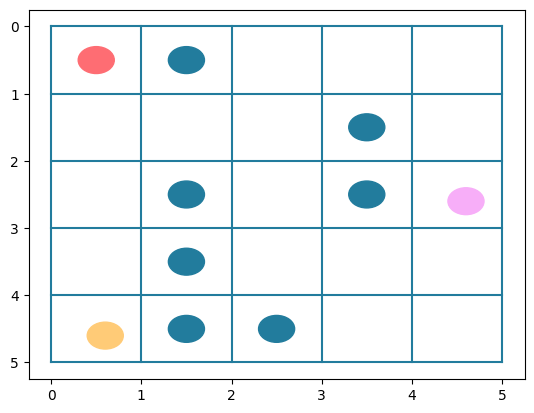

In [38]:
import matplotlib.pyplot as plt
import matplotlib.animation as mp_anim
import numpy as np

fig, ax = plt.subplots()
ax.yaxis.set_inverted(True)


for i in range(5 + 1):
    ax.plot(np.ones(100) * i, np.linspace(0, 5, 100), color="#227C9D")
    ax.plot(np.linspace(0, 5, 100), np.ones(100) * i, color="#227C9D")

for x in range(TAXI_MAP_SIZE):
    for y in range(TAXI_MAP_SIZE):
        if taxi_mappy[x, y] == TaxiTile.BUILDING:
            circle = plt.Circle((y + 0.5, x + 0.5), 0.2, color='#227C9D')
            ax.add_patch(circle)
        elif taxi_mappy[x, y] == TaxiTile.DROP_OFF:
            circle = plt.Circle((y + 0.6, x + 0.6), 0.2, color='#F7AEF8')
            ax.add_patch(circle)
        elif taxi_mappy[x, y] == TaxiTile.PICK_UP:
            circle = plt.Circle((y + 0.6, x + 0.6), 0.2, color='#FFCB77')
            ax.add_patch(circle)

taxi = plt.Circle((0 + 0.5, 0 + 0.5), 0.2, color='r')
ax.add_patch(taxi)

def animate(i):
    x, y, png = taxi_optimal_steps[i]
    taxi.set_center((y + 0.5, x + 0.5))
    color = "#fe6d73" if not png else "#17c3b2"
    taxi.set_color(color)

ani = mp_anim.FuncAnimation(fig, animate, frames=len(taxi_optimal_steps))

from IPython.display import HTML
HTML(ani.to_jshtml())

# Blackjack

In [8]:
# Assumptions:
#   - Every draw is independent of the previous draws,
#     meaning the probability of drawing 5 (or 10 000) of the same card is nonzero.
#   - The player has a fixed policy of always drawing until his score is 12 or higher,
#     because below that it is impossible to bust.


class BJAction(Enum):
    Hit = 0
    Stand = 1


POSSIBLE_DRAWS = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 10, 10, 10]


def draw_card():
    return np.random.choice(POSSIBLE_DRAWS, replace=True)


POSSIBLE_SUMS = range(12, 21 + 1)
POSSIBLE_DEALER_FACES = range(1, 10 + 1)


@lru_cache
def calculate_stand_score(dealer_sum, player_sum) -> float:
    scory = 0.0
    for draw in POSSIBLE_DRAWS:
        if dealer_sum + draw < 17:
            scory += calculate_stand_score(dealer_sum + draw, player_sum) / len(
                POSSIBLE_DRAWS
            )
        elif dealer_sum > 21:
            scory += 0  # dealer lost
        elif dealer_sum == player_sum:
            scory += 0
        elif dealer_sum < player_sum:
            scory += 1.0 / len(POSSIBLE_DRAWS)
        else:
            scory -= 1.0 / len(POSSIBLE_DRAWS)
    return scory


bj_model = gp.Model("blackjack_bajillionaire")
bj_gamma = 0.9

bj_V = np.empty((len(POSSIBLE_SUMS), len(POSSIBLE_DEALER_FACES)), dtype=object)
for my_sum in POSSIBLE_SUMS:
    for dealer_face in POSSIBLE_DEALER_FACES:
        bj_V[my_sum - 12, dealer_face - 1] = bj_model.addVar()
        # for a in BJAction:
        #     Qs[my_sum - 12, dealer_face - 1, a.value] = m.addVar()

for my_sum in POSSIBLE_SUMS:
    for dealer_face in POSSIBLE_DEALER_FACES:
        for action in BJAction:
            if action == BJAction.Stand:
                score = calculate_stand_score(dealer_face, my_sum)
                bj_model.addConstr(bj_V[my_sum - 12, dealer_face - 1] >= score)

            elif action == BJAction.Hit:
                prob_const = 1 / len(POSSIBLE_DRAWS)
                reward = (
                    -len([-1 for draw in POSSIBLE_DRAWS if my_sum + draw > 21])
                    * prob_const
                )

                bj_model.addConstr(
                    bj_V[my_sum - 12, dealer_face - 1]
                    >= reward + bj_gamma
                    * gp.quicksum(
                        [
                            bj_V[my_sum + draw - 12, dealer_face - 1]
                            for draw in POSSIBLE_DRAWS
                            if my_sum + draw <= 21
                        ]
                    )
                    * prob_const
                )

bj_model.setObjective((1 - bj_gamma) * gp.quicksum(bj_V[bj_V != None]), sense=GRB.MINIMIZE)
bj_model.optimize()

# We make the Q matrix after solving the problem because it avoids accidentally messing something up
bj_Q = np.empty((len(POSSIBLE_SUMS), len(POSSIBLE_DEALER_FACES), 2), dtype=object)

for my_sum in POSSIBLE_SUMS:
    for dealer_face in POSSIBLE_DEALER_FACES:
        for action in BJAction:
            if action == BJAction.Stand:
                score = calculate_stand_score(dealer_face, my_sum)
                bj_Q[my_sum - 12, dealer_face - 1, BJAction.Stand.value] = score

            elif action == BJAction.Hit:
                prob_const = 1 / len(POSSIBLE_DRAWS)
                reward = (
                    -len([-1 for draw in POSSIBLE_DRAWS if my_sum + draw > 21])
                    * prob_const
                )

                bj_Q[my_sum - 12, dealer_face - 1, BJAction.Hit.value] = reward + bj_gamma * sum(
                    [
                        bj_V[my_sum + draw - 12, dealer_face - 1].X
                        for draw in POSSIBLE_DRAWS
                        if my_sum + draw <= 21
                    ]
                ) * prob_const

# for my_sum in POSSIBLE_SUMS:
#     for dealer_face in POSSIBLE_DEALER_FACES:
#         print(Vs[my_sum - 12, dealer_face - 1].X, end=" ")
#     print()

my_sum = 14
dealer_face = 7
print(bj_Q[my_sum - 12, dealer_face - 1, BJAction.Stand.value])
print(bj_Q[my_sum - 12, dealer_face - 1, BJAction.Hit.value])



Gurobi Optimizer version 10.0.3 build v10.0.3rc0 (win64)

CPU model: 11th Gen Intel(R) Core(TM) i7-1165G7 @ 2.80GHz, instruction set [SSE2|AVX|AVX2|AVX512]
Thread count: 4 physical cores, 8 logical processors, using up to 8 threads

Optimize a model with 200 rows, 100 columns and 650 nonzeros
Model fingerprint: 0x6ea8355a
Coefficient statistics:
  Matrix range     [7e-02, 1e+00]
  Objective range  [1e-01, 1e-01]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-02, 1e+00]
Presolve removed 200 rows and 100 columns
Presolve time: 0.01s
Presolve: All rows and columns removed
Iteration    Objective       Primal Inf.    Dual Inf.      Time
       0    7.0599056e+00   0.000000e+00   0.000000e+00      0s

Solved in 0 iterations and 0.01 seconds (0.00 work units)
Optimal objective  7.059905596e+00
0.38156195541886434
-0.01408506981656854
